In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nikhilnellutla","key":"0c55af50bd4e42bb4fdee8babd200834"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [4]:
!kaggle datasets download -d issaisasank/guns-object-detection

Dataset URL: https://www.kaggle.com/datasets/issaisasank/guns-object-detection
License(s): GPL-2.0
  0% 0.00/4.89M [00:00<?, ?B/s]
100% 4.89M/4.89M [00:00<00:00, 879MB/s]


In [5]:
import zipfile

with zipfile.ZipFile("guns-object-detection.zip", "r") as zip_ref:
    zip_ref.extractall("guns_dataset")


In [6]:

import pandas as pd
import numpy as np
import cv2
import os
from numpy.core.defchararray import join,mod
import matplotlib.pyplot as plt
import albumentations as A
import requests
from io import BytesIO
from PIL import Image
import random
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
from torch._C import device
import torch.optim as optim
import torch.autograd.grad_mode as grad_mode
from torch.autograd import Function as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator




/tmp/ipython-input-4973163.py:5: DeprecationWarning: numpy.core.defchararray is deprecated and has been renamed to numpy._core.defchararray. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.defchararray.join.
  from numpy.core.defchararray import join,mod
/tmp/ipython-input-4973163.py:5: DeprecationWarning: numpy.core.defchararray is deprecated and has been renamed to numpy._core.defchararray. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumP

In [7]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [8]:
device

device(type='cpu')

In [9]:

def imgshow(number, title=None, base="/content/guns_dataset", size=5):
    """
    Robust image display with bounding boxes drawn.
    - number: image id (int or str)
    - title: optional title text (string)
    - base: dataset root folder (contains Images/ and Labels/)
    - size: base figure width in inches (height scaled by aspect ratio)
    """
    images_dir = os.path.join(base, "Images")
    labels_dir = os.path.join(base, "Labels")

    # find the image file
    found_image = None
    for ext in (".jpeg", ".jpg", ".png", ".bmp"):
        candidate = os.path.join(images_dir, f"{number}{ext}")
        if os.path.exists(candidate):
            found_image = candidate
            break

    # fallback: find any file that starts with the number (e.g. "0001.jpg")
    if found_image is None and os.path.isdir(images_dir):
        for fname in os.listdir(images_dir):
            if fname.startswith(str(number)):
                found_image = os.path.join(images_dir, fname)
                break

    if found_image is None:
        raise FileNotFoundError(f"No image found for id={number} in {images_dir}.")

    image = cv2.imread(found_image)
    if image is None:
        raise RuntimeError(f"cv2.imread failed to load: {found_image}")

    # find label file
    label_path = os.path.join(labels_dir, f"{number}.txt")
    if not os.path.exists(label_path) and os.path.isdir(labels_dir):
        for fname in os.listdir(labels_dir):
            if fname.startswith(str(number)) and fname.endswith(".txt"):
                label_path = os.path.join(labels_dir, fname)
                break
        else:
            label_path = None

    txt_data = []
    if label_path and os.path.exists(label_path):
        with open(label_path, "r") as f:
            # strip newline and ignore empty lines
            txt_data = [line.strip() for line in f.readlines() if line.strip() != ""]

    # parse and draw boxes
    h, w = image.shape[:2]
    if txt_data:
        # decide whether the first line is a count or a box
        try:
            first_val = int(txt_data[0])
            if len(txt_data) - 1 >= first_val:
                # first line is count
                count = first_val
                start_idx = 1
            else:
                # ambiguous: treat all lines as boxes
                count = len(txt_data)
                start_idx = 0
        except:
            count = len(txt_data)
            start_idx = 0

        for i in range(start_idx, start_idx + count):
            if i >= len(txt_data): break
            parts = txt_data[i].split()
            if len(parts) < 4:
                continue
            try:
                x1, y1, x2, y2 = [int(float(x)) for x in parts[:4]]
            except:
                continue
            # clamp to image bounds
            x1 = max(0, min(x1, w-1)); x2 = max(0, min(x2, w-1))
            y1 = max(0, min(y1, h-1)); y2 = max(0, min(y2, h-1))
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # compute aspect ratio and correct figsize (always a tuple)
    aspect_ratio = (h / w) if w != 0 else 1.0
    fig_width = float(size) if (isinstance(size, (int, float)) and size > 0) else 5.0
    fig_height = max(1.0, fig_width * aspect_ratio)
    figsize = (fig_width, fig_height)

    # debug info
    print(f"[imgshow] image={os.path.basename(found_image)}, shape={image.shape}, figsize={figsize}")

    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


[imgshow] image=119.jpeg, shape=(165, 305, 3), figsize=(5.0, 2.7049180327868854)


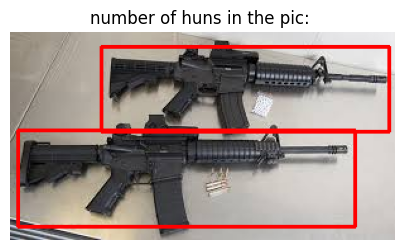

In [10]:
imgshow(119,title="number of huns in the pic: ")

In [11]:
from torch.utils.data import random_split

In [12]:
# Creating custom dataset


class Gun_Data(Dataset):
  def __init__(self, root):
    self.image_path = root + "/Images/"
    self.labels_path = root + "/Labels/"

    self.img_name = [img for img in sorted(os.listdir(self.image_path))]
    # fixed: use the correct attribute name (labels_path)
    self.label_name = [label for label in sorted(os.listdir(self.labels_path))]

  # fixed: correct special method name
  def __getitem__(self, idx):
    # fixed: use self.image_path (not self.img_path)
    img_path = os.path.join(self.image_path, str(self.img_name[idx]))
    image = cv2.imread(img_path)
    if image is None:
      raise FileNotFoundError(f"Failed to read image: {img_path}")

    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = img_rgb / 255.0
    # convert to tensor C,H,W
    img_res = torch.as_tensor(img_res).permute(2, 0, 1)

    # fixed: build label filename with ".txt"
    label_name = os.path.splitext(self.img_name[idx])[0] + ".txt"
    label_path = os.path.join(self.labels_path, label_name)



    box = []
    # fixed: call readline() and handle missing label file
    if not os.path.exists(label_path):
      raise FileNotFoundError(f"Label file not found: {label_path}")

    with open(label_path, 'r') as label_file:
      # call the function to get the first line
      first_line = label_file.readline().strip()
      # handle case where first line might be count or a box line
      try:
        l_count = int(first_line)
        # read next l_count lines
        for i in range(l_count):
          line = label_file.readline().strip()
          if not line:
            continue
          box.append(list(map(int, line.split())))
      except ValueError:
        # first line was not an int -> treat it as a box line
        if first_line:
          parts = first_line.split()
          if len(parts) >= 4:
            box.append(list(map(int, parts[:4])))
        # read remaining lines as boxes
        for line in label_file:
          line = line.strip()
          if not line:
            continue
          box.append(list(map(int, line.split())))

    target = {}
    area = []
    labels = []

    for i in range(len(box)):
      a = (box[i][2] - box[i][0]) * (box[i][3] - box[i][1])  # area formula
      area.append(a)

    for i in range(len(box)):
      labels.append(1)

    # ensure correct dtypes
    if len(box) == 0:
      boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
    else:
      boxes_tensor = torch.as_tensor(box, dtype=torch.float32)

    area_tensor = torch.as_tensor(area, dtype=torch.float32) if len(area) > 0 else torch.zeros((0,), dtype=torch.float32)
    labels_tensor = torch.as_tensor(labels, dtype=torch.int64) if len(labels) > 0 else torch.zeros((0,), dtype=torch.int64)
    image_id_tensor = torch.as_tensor([idx], dtype=torch.int64)

    target["boxes"] = boxes_tensor
    target["area"] = area_tensor
    target["image_id"] = image_id_tensor
    target["labels"] = labels_tensor

    # move to device only if device is defined in globals (keeps original behavior but safe)
    if "device" in globals():
      img_res = img_res.to(device)
      for key in target:
        if isinstance(target[key], torch.Tensor):
          target[key] = target[key].to(device)

    return img_res, target

  def __len__(self):
    return len(self.img_name)


In [13]:
#model training
class Model:
  def __init__(self,num):
    self.num = num
    self.model = self.create_model()

  def create_model(self):
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,self.num)
    return model
  def compiler(self,optimizer):
    self.optimizer = optimizer

  def train(self,train_data,val_data):
    for epoch in tqdm(range(num_epoch)):
      self.model = self.model.to(device)

      train_loss = 0
      self.model.train()

      for img,target in train_data:
        loss_dic = self.model(img,target)
        loss = sum(loss for loss in loss_dic.values())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        train_loss += loss.item()

      print(f"Epoch : {epoch+1} | Train loss : {train_loss}")



In [14]:
# create model
rcnn = Model(2)
model = rcnn.model

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epoch = 30

# compil
rcnn.compiler(optimizer)

# collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# dataset
dataset = Gun_Data('/content/guns_dataset')

# train–validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=3,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=3,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 127MB/s]


In [ ]:
rcnn.train(train_loader,val_loader)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
def test(data,number=random.randint(1,334)):
  img,target = data[number]
  model.eval()

  predictions = model([img])
  predictions= [{k:v.to(device) for k,v in t.items()} for t in predictions]
  return predictions,target,img

In [ ]:
def apply_nms(original_prediction,iou_threshold=None):
  keep = torchvision.ops.nms(original_prediction['boxes'],original_prediction['scores'],iou_threshold)
  final_prediction = original_prediction
  final_prediction["boxes"] = final_prediction['boxes'][keep]
  final_prediction["scores"] = final_prediction['scores'][keep]
  final_prediction["labels"] = final_prediction['labels'][keep]
  return final_prediction

In [ ]:
import torchvision.transforms as torchtrans


In [ ]:
def torch_to_pil(img):
  return torchtrans.ToPILImage()(img).convert('RGB')


In [ ]:
def plot_img_bbox(img,target,size=5):
  img_cv = cv2.cvtColor(np.array(img),cv2.COLOR_RGB2BGR)

  for  box in target["boxes"]:
    x,y,width,height = box.tolist()
    cv2.rectangle(img_cv,(int(x),int(y)),(int(x+width),int(y+height)),(0,0,255),2)

  aspect_ratio = img_cv.shape[0]/img_cv.shape[1]
  plt.figure(figsize=(size+aspect_ratio,size))
  plt.imshow(cv2.cvtColor(img_cv,cv2.COLOR_BGR2RGB))
  plt.show()


In [ ]:
prediction,target,img = test(dataset,number=10)

In [ ]:
prediction

In [ ]:
target

In [ ]:
img

In [ ]:
nms_pred=apply_nms(prediction[0],iou_threshold=0.7)

In [ ]:
nms_pred

In [ ]:
plot_img_bbox(torch_to_pil(img),target)